In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

%matplotlib inline
np.random.seed(1)  

In [2]:
iris = load_iris()
x = iris.data
y = iris.target.reshape(-1, 1)

perm = np.random.permutation(y.size)
x = x[perm][:]
y = y[perm][:]

encoder = OneHotEncoder(categories='auto', dtype=np.int)
y = encoder.fit_transform(y).toarray()

scaler = MinMaxScaler()
x = scaler.fit_transform(x)

print(x.shape, y.shape)

(150, 4) (150, 3)


In [3]:
class NeuralNetwork():
    def __init__(self, x, y, lr, params={}):
        self.x = x
        self.y = y
        self.lr = lr
        
        self.activation = self.relu if 'activation' in params and params['activation'] == 'relu' \
                              else self.tanh
        self.activation_prime = self.relu_prime if 'activation' in params \
                                    and params['activation'] == 'relu' else self.tanh_prime
        
        self.L = len(params['ln']) if 'ln' in params else 2
        self.ln = params['ln'] if 'ln' in params else [4, 8]
        
        self.w = []
        for l in range(self.L):
            self.w.append(self.random_initialize(self.ln[l], self.x.shape[0] if l == 0 else self.ln[l-1]))
        self.w.append(self.random_initialize(self.y.shape[0], self.ln[-1]))
        
        self.b = []
        for l in range(self.L + 1):
            self.b.append(self.random_initialize(1, 1))
        
        print('total trainable params: ', self.total_trainable_params())
        
    def random_initialize(self, *args):
        return 2 * np.random.rand(*args) - 1
        
    def sigmoid(self, x):
        z = np.exp(x - np.max(x))
        return z / z.sum(axis=0)
    
    def sigmoid_prime(self, x):
        return x * (1-x)
    
    def tanh(self, x):
        return np.tanh(x)
    
    def tanh_prime(self, x):
        return 1-(np.tanh(x)**2)
    
    def relu(self, x):
        return x * (x>0)
    
    def relu_prime(self, x):
        return np.where(x > 0, 1.0, 0.0)
    
    def loss(self, x):
        return np.mean(-self.y * np.log(x) - (1-self.y) * np.log(1-x))
    
    def loss_prime(self, x):
        return -(self.y/x) + ((1-self.y)/(1-x))
    
    def total_trainable_params(self):
        total = 0
        total += sum([b.size for b in self.b])
        total += sum([w.size for w in self.w])
        return total
    
    def forward_pass(self, x, probs=False):
        for i in range(self.L):
            layer_output = self.activation(np.dot(self.w[i], x if i == 0 else layer_output) + self.b[i])
        output = self.sigmoid(np.dot(self.w[-1], layer_output) + self.b[-1])
        
        if probs:
            output = output.T
            for i in range(output.shape[0]):
                temp = np.zeros(3)
                temp[np.argmax(output[i])] = 1
                output[i] = temp
            
            output = output.astype(np.int)
        
        return output
    
    def backward_pass(self, epochs):
        loss = np.zeros(epochs)
        
        for epoch in range(epochs):
            a = []
            for i in range(self.L):
                a.append(self.activation(np.dot(self.w[i], self.x if i == 0 else a[-1]) + self.b[i]))
            a.append(self.sigmoid(np.dot(self.w[-1], a[-1]) + self.b[-1]))
            
            loss[epoch] = self.loss(a[-1])
            
            dw = []
            db = []
            for i in reversed(range(self.L+1)):
                if i != self.L:
                    delta = np.dot(self.w[i+1].T, delta) * self.activation_prime(a[i])
                else:
                    delta = self.loss_prime(a[-1]) * self.sigmoid_prime(a[-1])
                
                dw.append(np.dot(delta, a[i-1].T if i != 0 else self.x.T) / self.x.shape[1])
                db.append(np.mean(delta))
                
            dw.reverse()
            db.reverse()
            
            for i in range(self.L):
                self.w[i] += -self.lr * dw[i]
                self.b[i] += -self.lr * db[i]
            
        return loss

total trainable params:  75
accuracy: 0.9666666666666667


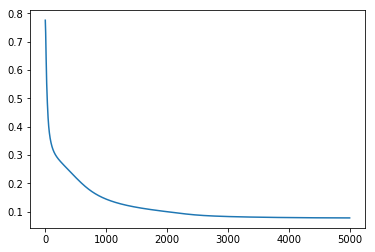

In [4]:
epochs = 5000
lr = 0.1
nn = NeuralNetwork(x.T, y.T, lr, params={'ln': [4, 8]})
losses = nn.backward_pass(epochs)

print(f'accuracy: {accuracy_score(nn.forward_pass(x.T, probs=True), y)}')

plt.plot(np.arange(epochs), losses)
plt.show()